In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

import re
from tqdm.notebook import tqdm
import requests
import datetime
import time
from collections import Counter
from random import uniform, randint
from IPython.display import clear_output
import warnings

warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from natasha import (Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger,
                     NewsNERTagger, Doc)

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import (ConfusionMatrixDisplay, confusion_matrix,
                             f1_score, classification_report)

import gc
import torch
import torchtext
import torch.nn as nn
from torch.optim import Adam
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
device = torch.device('cuda')

In [2]:
username = '...'
password = '...'
host = '...'
port = '...'
database = '...'

conn_string = f'postgresql://{username}:{password}@{host}:{port}/{database}'

In [3]:
def data_import_from_db(table_name, conn_string):
    db = create_engine(conn_string) 
    conn = db.connect() 
    conn.autocommit = True
    df = pd.read_sql_query(f'SELECT * FROM {table_name}', conn)
    conn.close()
    return df

# Setup

## Data

In [4]:
additional_stopwords = [
    'которых', 'которые', 'твой', 'которой', 'которого', 'сих', 'ком', 'свой',
    'твоя', 'этими', 'слишком', 'нами', 'всему', 'будь', 'саму', 'чаще',
    'ваше', 'сами', 'наш', 'затем', 'самих', 'наши', 'ту', 'каждое', 'мочь',
    'весь', 'этим', 'наша', 'своих', 'оба', 'который', 'зато', 'те', 'этих',
    'вся', 'ваш', 'такая', 'теми', 'ею', 'которая', 'нередко', 'каждая',
    'также', 'чему', 'собой', 'самими', 'нем', 'вами', 'ими', 'откуда',
    'такие', 'тому', 'та', 'очень', 'сама', 'нему', 'алло', 'оно', 'этому',
    'кому', 'тобой', 'таки', 'твоё', 'каждые', 'твои', 'нею', 'самим', 'ваши',
    'ваша', 'кем', 'мои', 'однако', 'сразу', 'свое', 'ними', 'всё', 'неё',
    'тех', 'хотя', 'всем', 'тобою', 'тебе', 'одной', 'другие', 'само', 'эта',
    'самой', 'моё', 'своей', 'такое', 'всею', 'будут', 'своего', 'кого',
    'свои', 'мог', 'нам', 'особенно', 'её', 'самому', 'наше', 'кроме',
    'вообще', 'вон', 'мною', 'никто', 'это'
]

stop_words = stopwords.words('russian') + additional_stopwords

In [5]:
# Natasha <3
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

ner_tagger = NewsNERTagger(emb)

In [6]:
del_n = re.compile('\n')
del_tags = re.compile('<[^>]*>')
del_brackets = re.compile('\([^)]*\)')
clean_text = re.compile('[^а-яa-z\s]')
del_spaces = re.compile('\s{2,}')


def prepare_text(text):
    text = del_n.sub(' ', str(text).lower())
    text = del_tags.sub('', text)
    text = del_brackets.sub('', text)
    res_text = clean_text.sub('', text)
    return del_spaces.sub(' ', res_text)


def del_stopwords(text):
    clean_tokens = tuple(
        map(lambda x: x if x not in stop_words else '', word_tokenize(text)))
    res_text = ' '.join(clean_tokens)
    return res_text


def lemmatize(text):
    text = Doc(text)
    text.segment(segmenter)
    text.tag_morph(morph_tagger)
    for token in text.tokens:
        token.lemmatize(morph_vocab)
    text.tag_ner(ner_tagger)
    for span in text.spans:
        span.normalize(morph_vocab)
    return ' '.join([token.lemma for token in text.tokens])

In [7]:
def preprocess_and_save(df, save_name):
    txt_lst = []
    txts = df.body.copy()

    for text in tqdm(txts):
        text = prepare_text(text)
        text = del_stopwords(text)
        text = lemmatize(text)
        txt_lst.append(text)
    
    # Save locally file with preprocessed texts (for convenience)
    df_safe = pd.concat(
        [df, pd.DataFrame(txt_lst, columns=['text_clear'])], axis=1)

    df_safe.to_csv(f'texts_{save_name}.csv', index=False)

In [8]:
def define_classes(df, main_col, class_col, p=0.05):
    df_ret = df.copy()

    q_l = df_ret[main_col].quantile(p)
    q_u = df_ret[main_col].quantile(1 - p)

    df_ret[class_col] = 1
    df_ret.loc[df_ret[main_col] <= q_l, class_col] = 0
    df_ret.loc[df_ret[main_col] >= q_u, class_col] = 2

    print(df_ret[class_col].value_counts())
    
    return df_ret

## Models

In [9]:
def plot_losses(train_losses, test_metrics):
    clear_output()
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    
def plot_metric(train_metrics, test_metrics):
    plt.figure(figsize=(6, 4))
    plt.plot(range(1, len(train_metrics) + 1), train_metrics, label='train', color='deepskyblue', linewidth=2)
    plt.plot(range(1, len(test_metrics) + 1), test_metrics, label='test', color='springgreen', linewidth=2)
    plt.ylabel('f1_macro')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [10]:
def create_dataset(X, y):
    data = []
    for i in range(X.shape[0]):
        data.append((y.values[i], X.values[i]))
    return data


def tokenizer(text):
    return text.split(' ')


def build_vocabulary(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)


def vectorize_batch(batch):
    global vocab, MAX_LEN
    
    Y, X = list(zip(*batch))
    # Tokenize and map tokens to indexes
    X = [vocab(tokenizer(text)) for text in X]
    # Bringing all samples to max_words length
    X = [
        tokens + ([0] * (MAX_LEN - len(tokens)))
        if len(tokens) < MAX_LEN else tokens[:MAX_LEN] for tokens in X
    ]

    return torch.tensor(
        X, dtype=torch.int32).to(device), torch.tensor(Y).to(device)

In [11]:
def init_data_and_vocab(texts, labels, min_freq):
    X_train, X_test, y_train, y_test = train_test_split(texts,
                                                        labels,
                                                        random_state=42,
                                                        test_size=0.25,
                                                        stratify=labels)

    class_weights = compute_class_weight(class_weight='balanced',
                                         classes=np.unique(y_train),
                                         y=y_train)

    train_dataset = create_dataset(X_train, y_train)
    test_dataset = create_dataset(X_test, y_test)

    vocab = build_vocab_from_iterator(build_vocabulary(
        [train_dataset, test_dataset]),
                                      min_freq=min_freq,
                                      specials=["<UNK>"])
    vocab.set_default_index(vocab["<UNK>"])

    print(f'Vocabulary size: {len(vocab)}')

    return train_dataset, test_dataset, vocab, class_weights


def init_loaders(train, test, batch_size):
    train = to_map_style_dataset(train)
    test = to_map_style_dataset(test)

    target_classes = [0, 1, 2]

    train_loader = DataLoader(train,
                              batch_size=batch_size,
                              collate_fn=vectorize_batch,
                              shuffle=True)
    test_loader = DataLoader(test,
                             batch_size=batch_size,
                             collate_fn=vectorize_batch)

    return train_loader, test_loader

In [12]:
class LSTMClassifier(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, vocab):
        super(LSTMClassifier, self).__init__()

        self.vocab = vocab
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding_layer = nn.Embedding(num_embeddings=len(self.vocab),
                                            embedding_dim=self.emb_dim)

        self.lstm = nn.LSTM(input_size=self.emb_dim,
                            hidden_size=self.hid_dim,
                            num_layers=self.n_layers,
                            batch_first=True)

        self.linear = nn.Linear(self.hid_dim, 3)

    def forward(self, X_batch):
        embeddings = self.embedding_layer(X_batch)
        hidden, carry = torch.zeros(self.n_layers,
                                    len(X_batch),
                                    self.hid_dim,
                                    device=device), torch.zeros(self.n_layers,
                                                                len(X_batch),
                                                                self.hid_dim,
                                                                device=device)
        output, (hidden, carry) = self.lstm(embeddings, (hidden, carry))
        return self.linear(output[:, -1])


def evaluate(model, loss_fn, val_loader):
    model.eval()
    Y_shuffled, Y_preds, losses = [], [], []

    for X, Y in val_loader:
        with torch.no_grad():

            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds = torch.cat(Y_preds)

    avg_loss = torch.tensor(losses).mean()
    f1_macro = f1_score(Y_shuffled.detach().cpu().numpy(),
                        Y_preds.detach().cpu().numpy(),
                        average='macro')

    return avg_loss, f1_macro, Y_preds, Y_shuffled


def train(model, loss_fn, optimizer, train_loader):
    model.train()
    Y_shuffled, Y_preds_l, losses = [], [], []
    for X, Y in train_loader:

        model.zero_grad()
        Y_preds = model(X)
        loss = loss_fn(Y_preds, Y)
        losses.append(loss.item())
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        Y_shuffled.append(Y)
        Y_preds_l.append(Y_preds.argmax(dim=-1))

    Y_shuffled = torch.cat(Y_shuffled)
    Y_preds_l = torch.cat(Y_preds_l)

    avg_loss = torch.tensor(losses).mean()
    f1_macro = f1_score(Y_shuffled.detach().cpu().numpy(),
                        Y_preds_l.detach().cpu().numpy(),
                        average='macro')

    return avg_loss, f1_macro

In [13]:
def rock_and_roll(model, loss_fn, optimer, train_loader, test_loader,
                  path_artifacts):
    best_test_metric = float('-inf')

    train_losses = []
    test_losses = []

    train_metrics = []
    test_metrics = []

    for epoch in tqdm(range(EPOCHS)):
        train_loss, train_metric = train(model, loss_fn, optimizer,
                                         train_loader)
        test_loss, test_metric, _, _ = evaluate(model, loss_fn, test_loader)

        if test_metric > best_test_metric:
            best_test_metric = test_metric
            torch.save(model, path_artifacts)

        train_losses.append(train_loss)
        train_metrics.append(train_metric)

        test_losses.append(test_loss)
        test_metrics.append(test_metric)

    plot_losses(train_losses, test_losses)
    plot_metric(train_metrics, test_metrics)

    torch.cuda.empty_cache()


def check_model(path_artifacts, loss_fn, test_loader):
    best_model = torch.load(path_artifacts)
    _, metric, pred_y, true_y = evaluate(best_model, loss_fn, test_loader)

    pred_y = pred_y.detach().cpu().numpy()
    true_y = true_y.detach().cpu().numpy()

    print(classification_report(true_y, pred_y))

# Model for the companies

In [20]:
df_comp = data_import_from_db('companies_trade', conn_string)

## Preprocessing

In [21]:
preprocess_and_save(df_comp, 'comp')

  0%|          | 0/7267 [00:00<?, ?it/s]

In [14]:
df_comp = pd.read_csv('texts_comp.csv')

for i, text in enumerate(df_comp.text_clear):
    df_comp.loc[i, 'text_clear'] = prepare_text(text).strip()

In [15]:
df_comp = define_classes(df_comp, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    6539
0     364
2     364
Name: count, dtype: int64


## Model

In [16]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/comp/comp_model.h5'
PATH_VOCABS = 'vocabs/comp_vocab.pt'

# Datasets
train_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_comp['text_clear'], labels=df_comp['price_diff_cat'], min_freq=6)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, test_loader = init_loaders(train_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 10516
Saved vocab size: 10516


In [21]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(10516, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 5326451

class_weights=array([6.65445665, 0.37044589, 6.65445665])


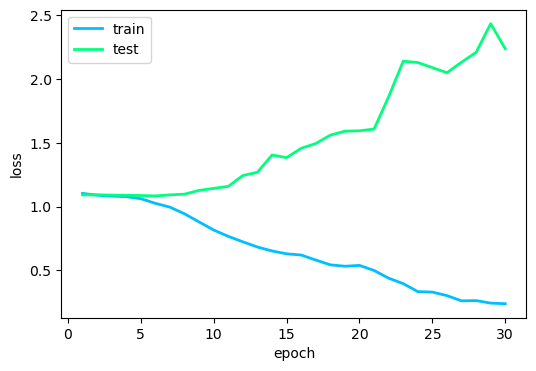

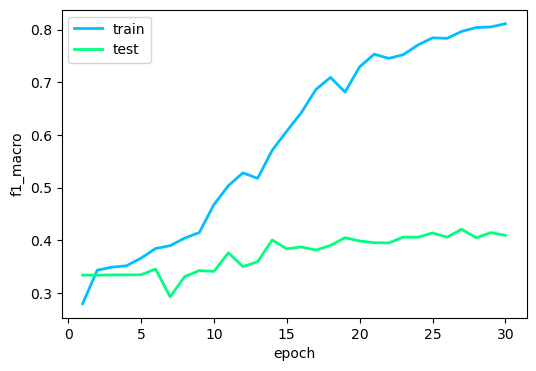

              precision    recall  f1-score   support

           0       0.20      0.20      0.20        91
           1       0.92      0.89      0.90      1635
           2       0.14      0.20      0.16        91

    accuracy                           0.82      1817
   macro avg       0.42      0.43      0.42      1817
weighted avg       0.84      0.82      0.83      1817

CPU times: total: 42.7 s
Wall time: 1min 34s


In [22]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

# Model for the industries

In [67]:
df_ind = data_import_from_db('industries_trade', conn_string)

## Preprocessing

In [68]:
preprocess_and_save(df_ind, 'ind')

  0%|          | 0/4755 [00:00<?, ?it/s]

In [23]:
df_ind = pd.read_csv('texts_ind.csv')

for i, text in enumerate(df_ind.text_clear):
    df_ind.loc[i, 'text_clear'] = prepare_text(text).strip()

In [24]:
df_ind = define_classes(df_ind, 'price_diff_percent', 'price_diff_cat', 0.05)

price_diff_cat
1    4279
2     238
0     238
Name: count, dtype: int64


## Model 

In [25]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/ind/ind_model.h5'
PATH_VOCABS = 'vocabs/ind_vocab.pt'

# Datasets
train_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_ind['text_clear'], labels=df_ind['price_diff_cat'], min_freq=6)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, test_loader = init_loaders(train_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 8163
Saved vocab size: 8163


In [30]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(8163, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 4149951

class_weights=array([6.67790262, 0.37041654, 6.6405959 ])


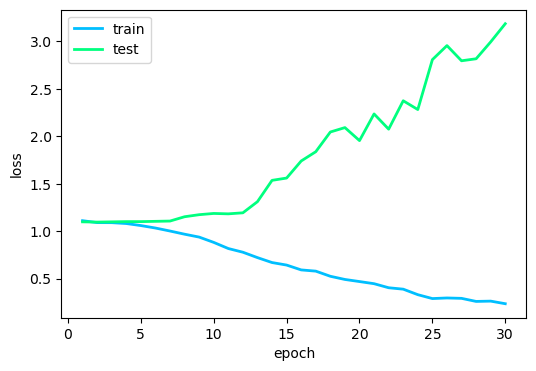

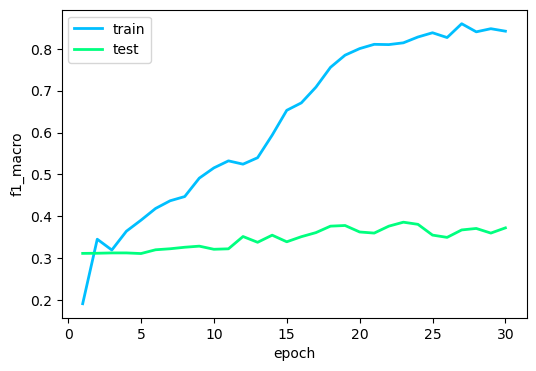

              precision    recall  f1-score   support

           0       0.11      0.13      0.12        60
           1       0.91      0.86      0.89      1070
           2       0.12      0.20      0.15        59

    accuracy                           0.79      1189
   macro avg       0.38      0.40      0.39      1189
weighted avg       0.83      0.79      0.81      1189

CPU times: total: 27.4 s
Wall time: 59 s


In [31]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

# Model for the global

In [10]:
df_glob = data_import_from_db('global_trade', conn_string)

## Preprocessing

In [24]:
preprocess_and_save(df_glob, 'glob')

  0%|          | 0/13304 [00:00<?, ?it/s]

In [32]:
df_glob = pd.read_csv('texts_glob.csv')

for i, text in enumerate(df_glob.text_clear):
    df_glob.loc[i, 'text_clear'] = prepare_text(text).strip()

In [33]:
df_glob = define_classes(df_glob, 'imoex_price_diff_percent', 'imoex_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'rvi_price_diff_percent', 'rvi_price_diff_cat', 0.05)
df_glob = define_classes(df_glob, 'usd_price_diff_percent', 'usd_price_diff_cat', 0.05)

imoex_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64
rvi_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64
usd_price_diff_cat
1    11972
0      666
2      666
Name: count, dtype: int64


## Models 

### Model MOEX

In [34]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_moex_model.h5'
PATH_VOCABS = 'vocabs/glob_moex_vocab.pt'

# Datasets
train_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob['text_clear'], labels=df_glob['imoex_price_diff_cat'], min_freq=6)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, test_loader = init_loaders(train_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 13443
Saved vocab size: 13443


In [35]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(13443, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 6789951

class_weights=array([6.66533066, 0.37041987, 6.652     ])


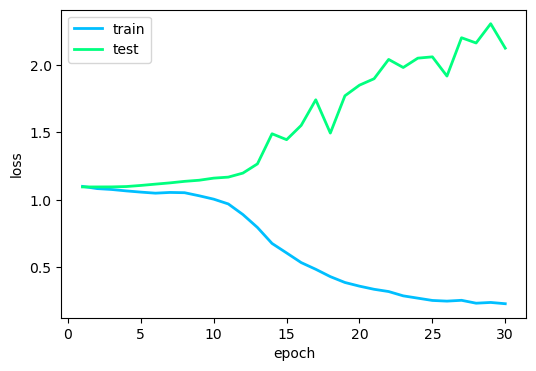

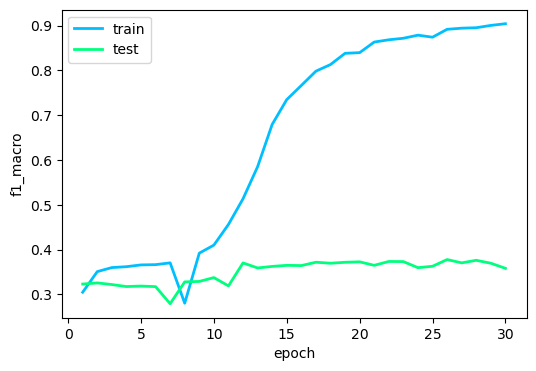

              precision    recall  f1-score   support

           0       0.09      0.15      0.11       167
           1       0.91      0.89      0.90      2993
           2       0.15      0.10      0.12       166

    accuracy                           0.82      3326
   macro avg       0.38      0.38      0.38      3326
weighted avg       0.83      0.82      0.82      3326

CPU times: total: 1min 16s
Wall time: 3min


In [36]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

### Model RVI

In [37]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_rvi_model.h5'
PATH_VOCABS = 'vocabs/glob_rvi_vocab.pt'

# Datasets
train_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob['text_clear'], labels=df_glob['rvi_price_diff_cat'], min_freq=6)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, test_loader = init_loaders(train_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 13443
Saved vocab size: 13443


In [42]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(13443, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 6789951

class_weights=array([6.66533066, 0.37041987, 6.652     ])


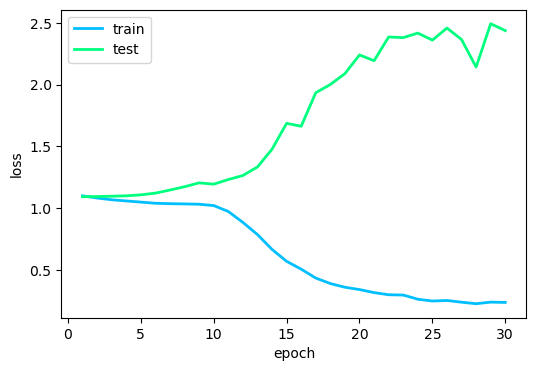

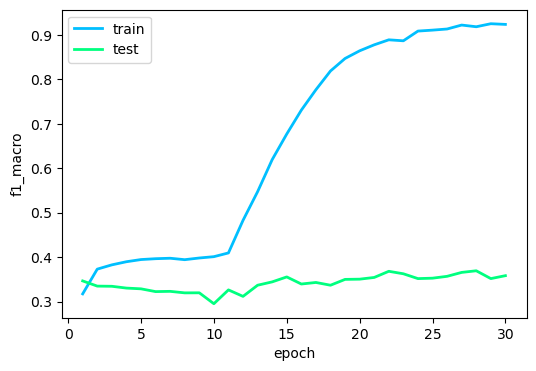

              precision    recall  f1-score   support

           0       0.12      0.19      0.15       167
           1       0.91      0.90      0.90      2993
           2       0.08      0.04      0.06       166

    accuracy                           0.82      3326
   macro avg       0.37      0.38      0.37      3326
weighted avg       0.83      0.82      0.82      3326

CPU times: total: 1min 24s
Wall time: 2min 26s


In [43]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

### Model RUBUSD

In [44]:
MAX_LEN = 500  # max length of each text (in terms of number of words)
BATCH_SIZE = 32  # batch size
EMBEDDING_DIM = 500  # dimension of word embeddings
HIDDEN_DIM = 32  # hidden dimension of LSTM
N_LAYERS = 1  # number of LSTM layers

EPOCHS = 30  # number of epochs
LR = 5e-4  # learning rate

PATH_ARTIFACTS = 'artifacts/glob/glob_rubusd_model.h5'
PATH_VOCABS = 'vocabs/glob_rubusd_vocab.pt'

# Datasets
train_dataset, test_dataset, vocab, class_weights = init_data_and_vocab(
    texts=df_glob['text_clear'], labels=df_glob['usd_price_diff_cat'], min_freq=6)
# Save vocab
torch.save(vocab, PATH_VOCABS)
# Check
print(f'Saved vocab size: {len(torch.load(PATH_VOCABS))}')

# Loaders
train_loader, test_loader = init_loaders(train_dataset, test_dataset,
                                         BATCH_SIZE)

Vocabulary size: 13443
Saved vocab size: 13443


In [47]:
# Model
model = LSTMClassifier(emb_dim=EMBEDDING_DIM,
                       hid_dim=HIDDEN_DIM,
                       n_layers=N_LAYERS,
                       vocab=vocab)
model = model.to(device)

param_num = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Model spec
print(model, '\n')
print(f'Number of parameters: {param_num}')

# Class weights
print(f'\n{class_weights=}')
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss and Opt
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = Adam(model.parameters(), lr=LR)

LSTMClassifier(
  (vocab): Vocab()
  (embedding_layer): Embedding(13443, 500)
  (lstm): LSTM(500, 32, batch_first=True)
  (linear): Linear(in_features=32, out_features=3, bias=True)
) 

Number of parameters: 6789951

class_weights=array([6.66533066, 0.37041987, 6.652     ])


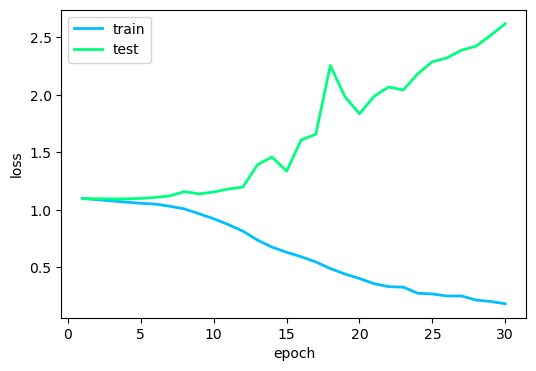

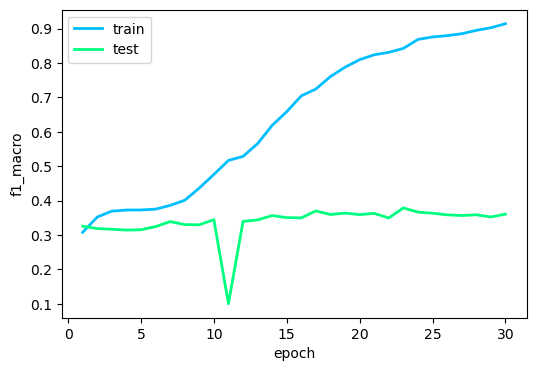

              precision    recall  f1-score   support

           0       0.09      0.13      0.11       167
           1       0.91      0.89      0.90      2993
           2       0.14      0.12      0.13       166

    accuracy                           0.82      3326
   macro avg       0.38      0.38      0.38      3326
weighted avg       0.83      0.82      0.82      3326

CPU times: total: 45.7 s
Wall time: 2min 56s


In [48]:
%%time
rock_and_roll(model=model,
              loss_fn=loss_fn,
              optimer=optimizer,
              train_loader=train_loader,
              test_loader=test_loader,
              path_artifacts=PATH_ARTIFACTS)

check_model(path_artifacts=PATH_ARTIFACTS,
            loss_fn=loss_fn,
            test_loader=test_loader)

# Upgraded tables save

In [75]:
def push_new_table_to_db(df, table_name, conn_string):
    db = create_engine(conn_string) 
    conn = db.connect() 
    conn.autocommit = True
    df.to_sql(table_name, con=conn, if_exists='replace', index=False) 
    conn.close()

In [76]:
push_new_table_to_db(df_comp, 'companies_trade_clear', conn_string)
push_new_table_to_db(df_ind, 'industries_trade_clear', conn_string)
push_new_table_to_db(df_glob, 'global_trade_clear', conn_string)

In [77]:
# Check 1
data_import_from_db('companies_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,company,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,text_clear,price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,SBER,142.75,11917688.40,142.62,2958789.90,-0.13,-0.091068,-8958898.5,-75.173122,порядок филиал исламский банкинг мочь дополнит...,1
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,GAZP,163.13,1100961.10,163.37,1413064.30,0.24,0.147122,312103.2,28.348250,объмый экспорт газпром пройти год снизиться ми...,1
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,ROSN,363.70,178263.05,364.85,321423.75,1.15,0.316195,143160.7,80.308679,правительство рф предоставить ямальский шельфо...,1
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,SBER,141.31,1573757.40,141.40,2401025.00,0.09,0.063690,827267.6,52.566399,минувший год запомниться инвестор время высоки...,1
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,GAZP,161.69,4620114.20,161.60,1373716.00,-0.09,-0.055662,-3246398.2,-70.266622,минувший год запомниться инвестор время высоки...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/951074.php,Аналитики Домклик Сбера: в сентябре 2023г боле...,Аналитики Домклик посчитали количество выдач л...,"['Сбербанк', 'Домклик', 'ипотека', 'ипотечное ...",1457,2023-10-17 15:19:00,SBER,270.57,46419415.30,269.98,9093523.40,-0.59,-0.218058,-37325891.9,-80.410086,аналитик домклик посчитать количество выдача л...,1
7263,Smart_Lab,Новости компаний и новости по акциям,https://smart-lab.ru/blog/951090.php,Темпы роста выручки X5 максимальные с 2017 год...,Чистая розничная выручка X5 Group за III кварт...,"['Х5 Retail Group', 'операционные результаты',...",1470,2023-10-17 15:50:00,FIVE,2380.50,228507.50,2384.50,357756.50,4.00,0.168032,129249.0,56.562257,чистый розничный выручка x group iii квартал г...,1
7264,РИА,Экономика,https://ria.ru/20231017/gaz-1903428772.html,Венгрия и Сербия пообещали Болгарии ответ на п...,Будапешт и Белград ответят на повышение плат...,"['Экономика', 'Россия', 'Венгрия', 'Сербия', '...",721,2023-10-17 18:13:00,GAZP,172.04,1367705.30,172.00,42397837.50,-0.04,-0.023250,41030132.2,2999.924925,будапешт белград ответить повышение плата тран...,1
7265,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926333,FESCO и Liaoning Port будут развивать перевозк...,- Транспортная группа FESCO (головная компан...,"['FESCO', 'ВМТП', 'ДВМП', 'Подмосковье', 'Кита...",918,2023-10-17 18:21:00,FESH,98.07,9807.00,98.70,118440.00,0.63,0.642398,108633.0,1107.708779,транспортный группа fesco группа компания порт...,2


In [78]:
# Check 2
data_import_from_db('industries_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,industry,price_release,volume_release,price_lag_30,volume_lag_30,price_diff,price_diff_percent,volume_diff,volume_diff_percent,text_clear,price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,MOEXFN,6307.20,1.680676e+07,6308.77,1.185410e+07,1.57,0.024892,-4.952657e+06,-29.468250,порядок филиал исламский банкинг мочь дополнит...,1
1,РИА,Экономика,https://ria.ru/20230103/gazprom-1842940413.html,"Экспорт ""Газпрома"" снизился до минимума с конц...","Объём экспорта ""Газпрома"" в прошедшем году с...","['Экономика', 'Газпром', 'Россия']",1299,2023-01-03 14:22:00,MOEXOG,5696.30,4.451181e+06,5696.72,4.605859e+06,0.42,0.007373,1.546786e+05,3.475002,объмый экспорт газпром пройти год снизиться ми...,1
2,РИА,Экономика,https://ria.ru/20230104/shelf-1843063413.html,Ямальской шельфовой компании предоставили два ...,Правительство РФ предоставило Ямальской шель...,"['Экономика', 'Карское море', 'Россия']",1719,2023-01-04 16:36:00,MOEXOG,5655.65,3.325798e+06,5663.65,1.490555e+06,8.00,0.141451,-1.835243e+06,-55.182029,правительство рф предоставить ямальский шельфо...,1
3,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXFN,6298.36,7.394623e+06,6296.27,3.371524e+06,-2.09,-0.033183,-4.023099e+06,-54.405737,минувший год запомниться инвестор время высоки...,1
4,Kommersant,Фондовый рынок,https://www.kommersant.ru/doc/5757640,Нестабильный рост,Минувший год запомнится инвесторам как время с...,None,12414,2023-01-06 10:02:00,MOEXOG,5655.00,1.594030e+07,5647.93,1.358916e+06,-7.07,-0.125022,-1.458139e+07,-91.474969,минувший год запомниться инвестор время высоки...,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4750,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926309,"СД ""Ростелекома"" рекомендовал дивиденды-2022 в...","- Совет директоров ПАО ""Ростелеком"" рекоменд...",['Ростелеком'],2096,2023-10-17 16:35:00,MOEXTL,2042.22,8.146566e+07,2041.61,2.950564e+07,-0.61,-0.029869,-5.196003e+07,-63.781504,совет директор пао ростелеком рекомендовать ак...,1
4751,РИА,Экономика,https://ria.ru/20231017/eksport-1903397700.html,ГД приняла в I чтении проект об экспорте СПГ б...,Госдума приняла в первом чтении законопроект...,"['Экономика', 'Газпром', 'Новатэк', 'Госдума Р...",1997,2023-10-17 17:09:00,MOEXOG,9157.44,3.539749e+07,9156.21,1.986335e+07,-1.23,-0.013432,-1.553413e+07,-43.884848,госдума принять первый чтение законопроект поз...,1
4752,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926319,"Принят в I чтении проект, разрешающий ""НОВАТЭК...",- Госдума РФ в первом чтении приняла законоп...,"['НОВАТЭК', 'Госдума']",3838,2023-10-17 17:17:00,MOEXOG,9155.69,1.499790e+07,9161.10,8.713726e+06,5.41,0.059089,-6.284177e+06,-41.900370,госдума рф первый чтение принять законопроект ...,1
4753,РИА,Экономика,https://ria.ru/20231017/gaz-1903428772.html,Венгрия и Сербия пообещали Болгарии ответ на п...,Будапешт и Белград ответят на повышение плат...,"['Экономика', 'Россия', 'Венгрия', 'Сербия', '...",721,2023-10-17 18:13:00,MOEXOG,9168.87,1.394318e+07,9169.17,1.687321e+07,0.30,0.003272,2.930027e+06,21.014044,будапешт белград ответить повышение плата тран...,1


In [79]:
# Check 3
data_import_from_db('global_trade_clear', conn_string)

,website,section,url,header,body,tags,body_length,datetime,imoex_price_release,imoex_price_lag_30,...,imoex_price_diff,imoex_price_diff_percent,rvi_price_diff,rvi_price_diff_percent,usd_price_diff,usd_price_diff_percent,text_clear,imoex_price_diff_cat,rvi_price_diff_cat,usd_price_diff_cat
0,РИА,Экономика,https://ria.ru/20230103/banki-1842907991.html,Эксперт рассказал о развитии исламского банкин...,Порядка 10-15 филиалов исламского банкинга м...,"['Экономика', 'Россия', 'Сбербанк России']",1759,2023-01-03 10:16:00,2166.77,2168.03,...,1.26,0.058151,-0.19,-0.469716,-377.0,-0.535877,порядок филиал исламский банкинг мочь дополнит...,1,1,0
1,РИА,Экономика,https://ria.ru/20230103/avtomobili-1842908567....,Минпромторг спрогнозировал рост производства а...,Минпромторг прогнозирует в наступившем году ...,"['Экономика', 'Авто', 'Денис Мантуров', 'Росси...",808,2023-01-03 10:20:00,2166.37,2167.18,...,0.81,0.037390,-0.20,-0.494438,-256.0,-0.364340,минпромторг прогнозировать наступить год увели...,1,1,0
2,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/879539,Рынок акций РФ открылся ростом индекса МосБирж...,- Рынок акций РФ открылся во вторник ростом ...,['Московская биржа'],1249,2023-01-03 10:22:00,2166.08,2166.96,...,0.88,0.040626,-0.21,-0.519159,-159.0,-0.226573,рынок акция рф открыться вторник рост рублевый...,1,1,1
3,РИА,Экономика,https://ria.ru/20230103/nissan-1842909188.html,"""АвтоВАЗу"" передадут активы Nissan в России","Подведомственное Минпромторгу ФГУП ""НАМИ"" пе...","['Экономика', 'Авто', 'Денис Мантуров', 'Минис...",1414,2023-01-03 10:29:00,2168.32,2168.95,...,0.63,0.029055,0.36,0.903161,93.0,0.132760,подведомственный минпромторг фгуп передавать а...,1,1,1
4,РИА,Экономика,https://ria.ru/20230103/kazakhstan-1842940182....,Путин и Токаев обменялись по телефону поздравл...,Владимир Путин и президент Казахстана Касым-...,"['Владимир Путин', 'Касым-Жомарт Токаев', 'В м...",752,2023-01-03 14:20:00,2169.06,2169.46,...,0.40,0.018441,0.72,1.836735,-104.0,-0.145518,владимир путин президент казахстан касымжомарт...,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13299,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926333,FESCO и Liaoning Port будут развивать перевозк...,- Транспортная группа FESCO (головная компан...,"['FESCO', 'ВМТП', 'ДВМП', 'Подмосковье', 'Кита...",918,2023-10-17 18:21:00,3249.29,3247.15,...,-2.14,-0.065861,-0.08,-0.304646,-29.0,-0.029417,транспортный группа fesco группа компания порт...,1,1,1
13300,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926338,Аналитики ЦБ отметили в сентябре новый импульс...,- Экономическая активность в России в целом ...,"['Банк России', 'Минэкономразвития']",2351,2023-10-17 18:33:00,3252.16,3247.15,...,-5.01,-0.154051,0.38,1.472868,-103.0,-0.104403,экономический активность россия целое оставать...,1,1,1
13301,РИА,Экономика,https://ria.ru/20231017/zernovye-1903437148.html,В этом году Россия поставила миллион тонн зерн...,Россия в текущем году уже поставила миллион ...,"['Россия', 'Пакистан', 'Владимир Путин', 'Экон...",224,2023-10-17 18:46:00,3247.15,3246.91,...,-0.24,-0.007391,0.17,0.649351,9.0,0.009130,россия текущий год поставить миллион тонна зер...,1,1,1
13302,Интерфакс,ЭКОНОМИКА,https://www.interfax.ru/business/926342,Инфляция в России может превысить прогноз ЦБ в...,В ЦБ отметили преобладание проинфляционных рис...,['Банк России'],1841,2023-10-17 18:56:00,3246.83,3247.89,...,1.06,0.032647,2.56,10.130590,105.0,0.106534,цб отметить преобладание проинфляционный риск ...,1,2,1
